### Dataset

#### experimental structure
5 runs <br>
12 trials per run <br>
4 conditions 
- cond 1: low GO, low U
- cond 2: low GO, high U
- cond 3: high GO, low U
- cond 4: high GO, high U <br>

No_subs = 49

No_conditions = 6 <br>
6 types of events per trial <br>
list of conditions: 'caught', 'chase', 'checkpoint', 'close_enemy', 'protected_by_wall', 'vc_hit' <br>

#### possibilities of modelling data per sub
- __one beta map per run__
- one beta map per x trials, x={1,2,3,6}
- one beta map per condition --> we will model conditions rather than the events within a trial

#### tutorial link
https://peerherholz.github.io/workshop_weizmann/advanced/machine_learning_nilearn.html

In [1]:
import nibabel as nib
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA


from nilearn.maskers import NiftiMasker
from nilearn.masking import compute_brain_mask
from nilearn.image import math_img
from nilearn.plotting import plot_stat_map
from nilearn.plotting import plot_roi

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score
from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

from function import *

# Data Loading and Visualization

In [2]:
# load beta images
# And clean them, replacing nans by 0s ...
from nilearn.image import clean_img
beta_maps_dir = 'data/beta_maps'
beta_maps = []
for file in sorted(os.listdir(beta_maps_dir)):
    if file.endswith('.nii.gz'):
        map = nib.load(os.path.join(beta_maps_dir, file))
        beta_maps.append(clean_img(map, standardize=False, ensure_finite=True))

nb_sub = len(beta_maps)

print('Number of subjects: ', nb_sub)

Number of subjects:  49


## Creation of the mask

Shape of the mask:  (91, 109, 91)


/opt/anaconda3/envs/MVAP/lib/python3.8/site-packages/nilearn/plotting/img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


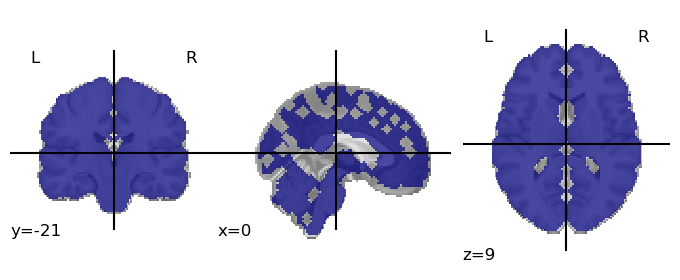

In [3]:
anat_path = 'data/anatomy/mask.nii'
anatomy = nib.load(anat_path)
mask = compute_brain_mask(anatomy)

print('Shape of the mask: ', mask.shape)
plot_roi(mask)

## Masking the data

In [4]:
masker = NiftiMasker(mask_img=mask)

samples = []
for map in tqdm(beta_maps):
    samples.append(masker.fit_transform(map))
samples = np.concatenate(samples, axis=0)

100%|███████████████████████████████████████████| 49/49 [00:15<00:00,  3.22it/s]


In [5]:
print("We have 49 subjects, and for each of them there are 30 beta maps. Hence we have", samples.shape[0],
      "observations and",  samples.shape[1], "features")

We have 49 subjects, and for each of them there are 30 beta maps. Hence we have 1470 observations and 216734 features


## Labels 

In [6]:
labels = np.tile(['caught', 'chase', 'checkpoint', 'close_enemy', 'protected_by_wall', 'vc_hit'], 5*nb_sub)
print('Numbers of labels/training samples: ', len(labels))

Numbers of labels/training samples:  1470


# Classification

- Baseline model with original dataset
- Tuned Model with features extraction (PCA)
- SpaceNet 


    
https://www.cs.purdue.edu/homes/jhonorio/fmrisynth_bookchapter14.pdf


## Baseline

In order to estimate the generalization accuracy of the classifiers : 

• k-fold cross-validation. We hold out S/k samples in turn while training
on the other S(k − 1)/k samples. The held out samples are used for
measuring the classification accuracy.

• Independent set. After training in the whole dataset of  samples,
we measure the classification accuracy in an independent set of 4 subject (20 samples).

### Cross Validation strategies

- 5-fold CV
- leave 1 run out across all subjects
- (run a model per sub, leave 1 run out within subject)

In [7]:
np.random.seed(4)
chunks_CV = {}
for key in ['per_9subjects', 'per_run'] :
    chunks_CV[key]=eval('make_chunks_'+key)(49)
    
classifiers = {'Ridge' :RidgeClassifier(),  'GaussianNB' : GaussianNB(), 'RandomForest' : RandomForestClassifier() }
dic_cv_scores={}

In [ ]:
for name, clf in classifiers.items() : 
    print('\n'+ name + ', 5fold CV :')
    cv_scores=cross_val_score(estimator=clf,
                            X=samples,
                            y=labels,
                            cv=5,
                            n_jobs=-1,
                            verbose=1)
    
    dic_cv_scores[name+'5FCV'] = cv_scores.mean()
    
    #print score per fol & the mean of it
    print('Average accuracy = %.02f percent\n' % (cv_scores.mean() * 100))
    print('Accuracy per fold:', cv_scores, sep='\n')
    
    
    for key, chunk in chunks_CV.items() : 
        print('\n'+ name + ','+ key + ' :' )
        cv_scores = cross_val_score(estimator=clf,
                            X=samples,
                            y=labels,
                            groups=chunk,
                            cv=LeaveOneGroupOut(),
                            n_jobs=-1,
                            verbose=1)
        
        dic_cv_scores[name+'_'+key]= cv_scores.mean()
        
        #print score per fol & the mean of it
        print('Average accuracy = %.02f percent\n' % (cv_scores.mean() * 100))
        print('Accuracy per fold:', cv_scores, sep='\n')

### Independent set

In [25]:
nb_test = 4
test_samples = samples[0:nb_test*30,:]
train_samples = samples[nb_test*30:nb_sub*30,:]

test_labels = labels[0:nb_test*30]
train_labels = labels[nb_test*30:nb_sub*30]

In [26]:
for name, clf in classifiers.items() : 
    print('\n'+ name )
    
    clf.fit(train_samples, train_labels)
    train_error = clf.score(train_samples, train_labels)
    condition_pred=clf.predict(test_samples)
    test_error = accuracy(test_labels, condition_pred)
    

    #print score per fold & the mean of it
    print('Train accuracy : ', train_error)
    print('Test accuracy :',  test_error)


Ridge


/opt/anaconda3/envs/MVAP/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.88837e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


Train accuracy :  0.9992592592592593
Test accuracy : 0.575

GaussianNB
Train accuracy :  0.7814814814814814
Test accuracy : 0.6416666666666667

RandomForest
Train accuracy :  1.0
Test accuracy : 0.775


## Tuned Model with or without features extraction

- Tunning without PCA 
- PCA & Tunning

In [8]:
def run_1 (pipeline, grid, name_clf, type_) :
    
    print('\n'+ name_clf + ', 5fold CV : \n')
    
    grid_result = GridSearchCV(pipeline, param_grid = grid, scoring = 'accuracy', verbose=1, n_jobs=-1, cv = 5)
    grid_result.fit(samples, labels)
    
    print('Mean test score :' , grid_result.cv_results_['mean_test_score'], '\n')
    print(' Test score std  :', grid_result.cv_results_['std_test_score'], '\n')
    
    print('Best Score: ', grid_result.best_score_) 
    print('Best Params: ', grid_result.best_params_) 
    dic_cv_scores[name_clf+'_5FCV_'+type_]=(grid_result.best_score_)
    
    for key, chunk in chunks_CV.items():
        print('\n'+name_clf+ ' , ' +  key +' : \n')
        
        grid_result = GridSearchCV(pipeline, param_grid = grid, scoring = 'accuracy', verbose=1, n_jobs=-1, cv = LeaveOneGroupOut() )
        grid_result.fit(samples, labels, groups = chunk)
        
        print('Mean test score :' , grid_result.cv_results_['mean_test_score'], '\n')
        print(' Test score std  :', grid_result.cv_results_['std_test_score'], '\n')
    
              
        dic_cv_scores[name_clf+'_'+key+type_]= grid_result.best_score_
        print('Best Score: ', grid_result.best_score_) #Mean cross-validated score of the best_estimator
        print('Best Params: ', grid_result.best_params_) 

### Cross Validation strategies

- 5-fold CV
- leave 1 run out across all subjects
- leave a set of subject (7*9) across all subject 

### Tunning without PCA

*NB*:  var_smoothing is a stability calculation to widen (or smooth) the curve and therefore account for more samples that are further away from the distribution mean. In this case, np.logspace returns numbers spaced evenly on a log scale, starts from 0, ends at -9, and generates 25 samples. 

In [9]:
grid_ridge = {'Ridge__alpha': [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1] }

grid_GaussianNB = {'GaussianNB__var_smoothing': np.logspace(0,-9, num=25)} 

grid_Forest = {'RandomForest__max_depth' :[int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]}

In [ ]:
for name, clf in classifiers.items():
    
    if (name=='Ridge'): param_grid = grid_ridge
    if (name=='GaussianNB'): param_grid = grid_GaussianNB
    if(name=='RandomForest') : param_grid = grid_Forest 
    
    
    pipe = Pipeline([(name ,clf)])
    
    run_1(pipe, param_grid, name, '_Tuned')

### Tunning with PCA 

In [10]:
for name, clf in classifiers.items():
    
    if (name=='Ridge'): param_grid = grid_ridge
    if (name=='GaussianNB'): param_grid = grid_GaussianNB
    if(name=='RandomForest') : param_grid = grid_Forest 
    
    pipe = Pipeline([('scale', MinMaxScaler()), ('pca' , PCA(n_components=150)), (name ,clf)])
    
    run_1(pipe, param_grid, name, '_PCA_tuned')


Ridge, 5fold CV : 

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Mean test score : [0.76734694 0.76870748 0.76462585 0.7755102  0.75986395 0.76598639] 

 Test score std  : [0.03092059 0.03631659 0.03300547 0.03325689 0.03538723 0.03832535] 

Best Score:  0.7755102040816326
Best Params:  {'Ridge__alpha': 0.01}

Ridge , per_9subjects : 

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Mean test score : [0.76281481 0.75992593 0.76496296 0.76118519 0.76540741 0.76066667] 

 Test score std  : [0.04098285 0.04638031 0.03871715 0.04709003 0.03364186 0.03855155] 

Best Score:  0.7654074074074074
Best Params:  {'Ridge__alpha': 0.1}

Ridge , per_run : 

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Mean test score : [0.7707483  0.7707483  0.76258503 0.77210884 0.77142857 0.76530612] 

 Test score std  : [0.05311353 0.05346091 0.05619558 0.05429407 0.04930917 0.05321798] 

Best Score:  0.7721088435374149
Best Params:  {'Ridge__alpha': 0.01}

GaussianNB, 5

KeyboardInterrupt: 

In [ ]:
for model, score in  dic_cv_scores.items():
    print ('- ', model, ' : ' , score, '\n')

# SpaceNet : SpaceNet: decoding with spatial structure for better maps

# Searchlight :  
small group of neighboring features is extracted from the data, and the prediction function is instantiated on these features only. The resulting prediction accuracy is thus associated with all the features within the group, or only with the feature on the center. This yields a map of local fine-grained information, that can be used for assessing hypothesis on the local spatial layout of the neural code under investigation

In [16]:
from nilearn.decoding import SpaceNetClassifier
decoder = SpaceNetClassifier(penalty='tv-l1',
                             mask=mask,
                             max_iter=10, # We need to change this to 1000 but even 10 takes a lot of time
                             cv=5,
                             standardize=True,
                             memory="nilearn_cache",
                             memory_level=2,
                             verbose=1)

# We need to input 4D images to decoder.fit but we input a list of 4D images. I couldn't find a solution online :(
# I didn't use train_samples and train_labels beacuse decoder.fit wants NIFTI images
decoder.fit(beta_maps, labels)

[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask


DimensionError: Input data has incompatible dimensionality: Expected dimension is 4D and you provided a list of 4D images (5D). See https://nilearn.github.io/stable/manipulating_images/input_output.html.

In [17]:
# Prediction
test_pred = decoder.predict(test_samples)
# Return average accuracy
accuracy = (test_pred == test_labels).mean() * 100.
print("\nTV-l1  classification accuracy : %g%%" % accuracy)

TypeError: Data given cannot be loaded because it is not compatible with nibabel format:
0.0

In [18]:
from nilearn.plotting import plot_stat_map, show
coef_img = decoder.coef_img_

# Plotting the searchlight results on the glass brain
from nilearn.plotting import plot_glass_brain
plot_glass_brain(coef_img, black_bg=True, colorbar=True, display_mode='lyrz', symmetric_cbar=False,
                 cmap='magma', title='graph-net: accuracy %g%%' % accuracy)

AttributeError: 'SpaceNetClassifier' object has no attribute 'coef_img_'

In [19]:
from nilearn.decoding import SearchLight
from nilearn.image import new_img_like
from nilearn.plotting import plot_glass_brain

In [20]:
sphere_radius = 8  # in mm

In [21]:
for name, clf in classifiers.items() : 
    for key, chunk in chunks.items() : 
        print('\n' + name + ','+ key+ ' : ')
        sl=SearchLight(mask, process_mask_img=mask,radius=sphere_radius, 
                 estimator=clf,
                 cv=LeaveOneGroupOut(),
                 n_jobs=1,
                 verbose=1)
        sl.fit(beta_maps, labels, groups=chunk)
        searchlight_img = new_img_like(beta_maps[0], sl.scores_)
        plot_glass_brain(searchlight_img, black_bg=True, colorbar=True, display_mode='lyrz',
                 threshold=0.6, cmap='magma', title='Searchlight Prediction Accuracy '+ name +' ' + key)



Ridge,per_5fold : 


DimensionError: Input data has incompatible dimensionality: Expected dimension is 4D and you provided a list of 4D images (5D). See https://nilearn.github.io/stable/manipulating_images/input_output.html.